In [1]:
from CookieTTS._2_ttm.flowtts.model import FlowTTS
from CookieTTS._2_ttm.flowtts.model import load_model
from CookieTTS._2_ttm.flowtts.hparams import create_hparams
from CookieTTS.utils.audio.stft import TacotronSTFT, STFT
from CookieTTS.utils.text import text_to_sequence

import sys
sys.path.append('../_4_mtw/waveglow') # add WaveGlow to System path for easier importing
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
D:\Miniconda\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def plot_data(data, title=None, figsize=(20, 3.5)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        if title:
            axes[i].set_title(title[i])
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [3]:
hparams = create_hparams()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Speaker ID = tensor([5], device='cuda:0')
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_2000
On iter 2000
Text: `One. Two.`          [mean -5.469117] [max -2.227848] [min -8.964258]
Text: `Flow T T S.`        [mean -5.541471] [max -2.223942] [min -8.876057]
Text: `Sssssssssss`        [mean -5.570306] [max -2.318251] [min -8.991407]
Text: `Twilight Sparkle`   [mean -5.573901] [max -2.225117] [min -8.946165]
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_4000
On iter 4000
Text: `One. Two.`          [mean -5.049891] [max -1.761168] [min -8.363190]
Text: `Flow T T S.`        [mean -5.027565] [max -1.948032] [min -8.358076]
Text: `Sssssssssss`        [mean -5.040824] [max -1.954355] [min -8.378008]
Text: `Twilight Sparkle`   [mean -5.066412] [max -1.889130] [min -8.623741]
G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model
On iter 8000
Text: `One. Two.`          [mean -4.770588] [max -1.747501] [min -8.037128]
Text: `Flow T T S.`        

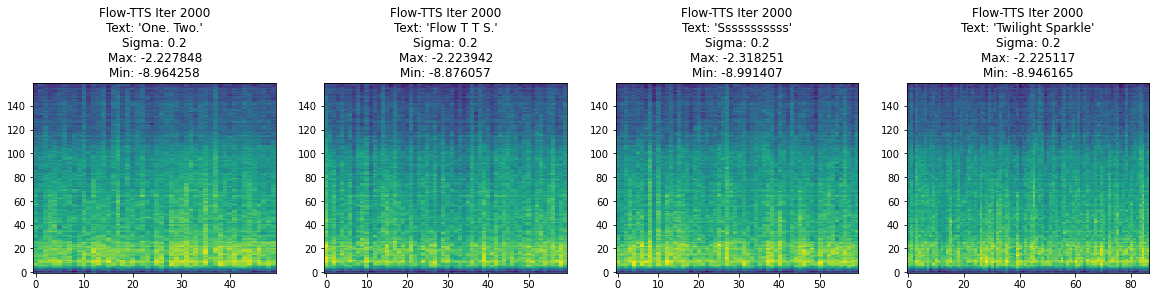

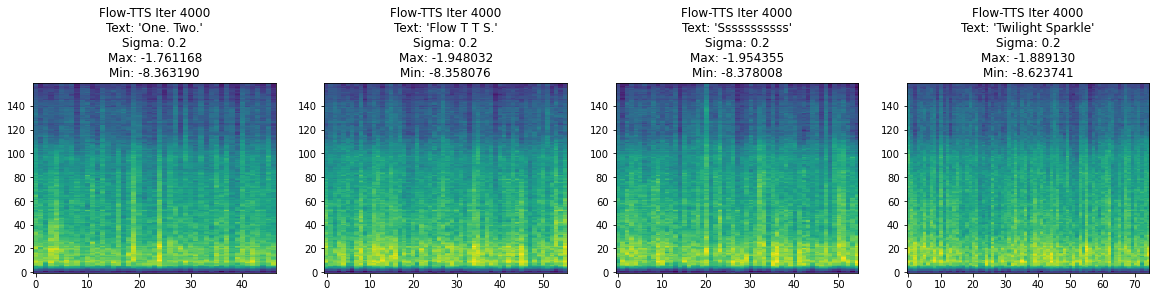

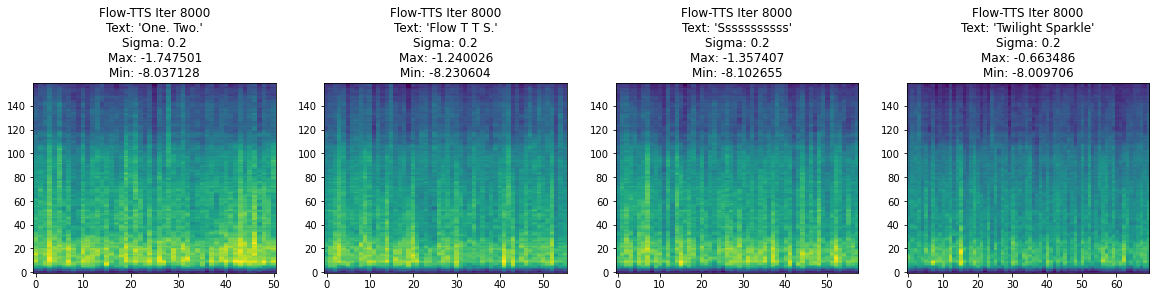

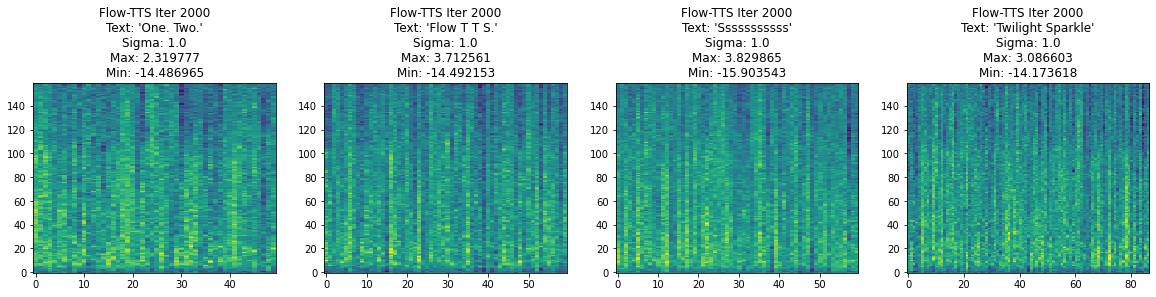

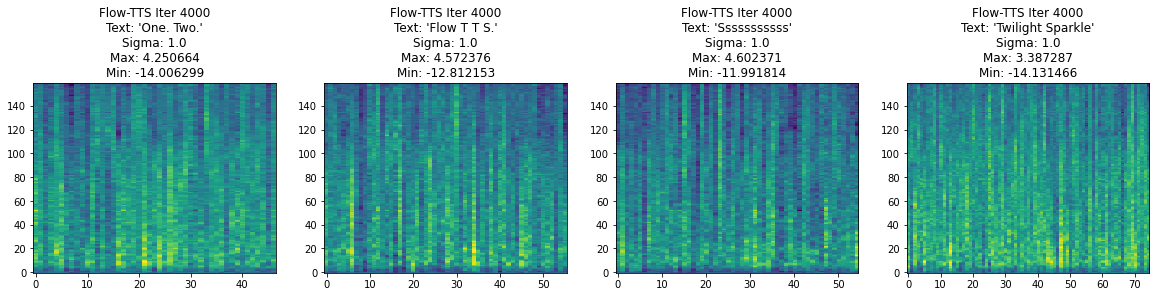

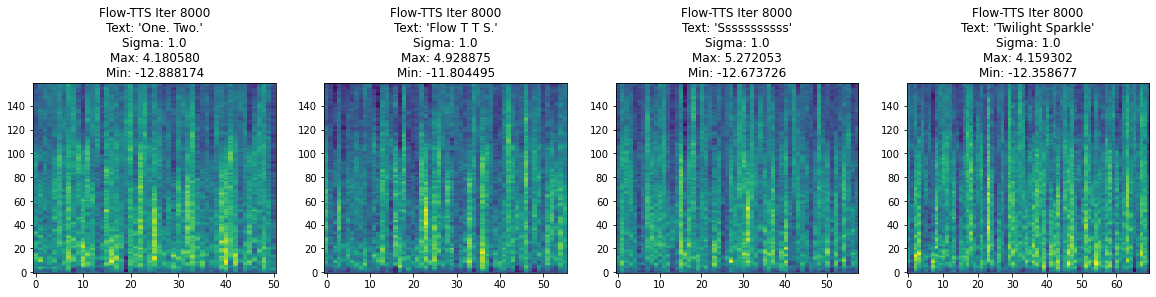

In [27]:
checkpoint_paths = [
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_2000",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\checkpoint_4000",
    r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model",
]

texts = [
    "One. Two.",
    "Flow T T S.",
    "Sssssssssss",
    "Twilight Sparkle",
]

sigma = [0.2,1.0,]

# Speaker IDs
speaker_ids = torch.LongTensor([5,]).cuda()
print('Speaker ID =', speaker_ids)
# Generate
with torch.no_grad():
    for sigma_ in sigma:
        for i, checkpoint_path in enumerate(checkpoint_paths):
            print(checkpoint_path)
            checkpoint = torch.load(checkpoint_path)
            iteration = checkpoint['iteration']
            print(f"On iter {iteration}")
            model = load_model(hparams)
            model.load_state_dict(checkpoint['state_dict'])
            _ = model.cuda().eval()
            mel_outputs = []
            titles=[]
            for text in texts:
                sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
                sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                mel_output, *_ = model.inference(sequence, speaker_ids, sigma=sigma_)
                mel_output = (mel_output-3.5)*8 # inverse transform magnitudes from -1 -> 1 to -11.5 -> 4.5
                
                print(f'Text: {"`"+text+"`":20} [mean {mel_output.mean().item():.6f}] [max {mel_output.max().item():.6f}] [min {mel_output.min().item():.6f}]')
                mel_outputs.append(mel_output)
                titles.append(f"Flow-TTS Iter {iteration}\nText: '{text}'\nSigma: {sigma_}\nMax: {mel_output.max().item():.6f}\nMin: {mel_output.min().item():.6f}")
            plot_data((*[x.float().cpu().numpy()[0] for x in mel_outputs],), title=titles)

In [5]:

#log_s, t = self.WN(audio_0_out, spect, speaker_ids)
audio_1_out = (torch.rand(5)-0.5)*2**31
log_s = (torch.rand(5)-0.5)*2**31
t = (torch.rand(5)-0.5)*2**31
audio_1 = (audio_1_out - t) / log_s.exp()
print(audio_1)
print(audio_1.mean())

tensor([-0., 0., inf, inf, 0.])
tensor(inf)


In [6]:
1/(torch.ones(5) * -2e31).exp()

tensor([inf, inf, inf, inf, inf])

In [7]:
checkpoint_path = r"G:\TwiBot\CookiePPPTTS\CookieTTS\_2_ttm\flowtts\outdir\best_model"
checkpoint = torch.load(checkpoint_path)
model = load_model(hparams)
model.load_state_dict(checkpoint['state_dict'])
_ = model.cuda().eval()

In [8]:
for i in range(10):
    print( torch.isnan( model.decoder.glow.convinv[i].weight.squeeze().inverse() ).any() )

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')


In [9]:
inv_w = model.decoder.glow.convinv[0].weight.squeeze().inverse()

In [10]:
inv_w.max()

tensor(0.3084, device='cuda:0', grad_fn=<MaxBackward1>)

In [11]:
inv_w.min()

tensor(-0.3267, device='cuda:0', grad_fn=<MinBackward1>)

In [12]:
inv_w.logdet()

tensor(-0.2211, device='cuda:0', grad_fn=<LogdetBackward>)

## Other stuff

In [13]:
import numpy as np
sigma = 1.0
0.5 * np.log(2 * np.pi) + np.log(sigma)

0.9189385332046727

In [14]:
(0.5 * np.log(2 * np.pi) + np.log(sigma))*10

9.189385332046726

In [15]:
print(
    f"{.9189385332046727:6.4}",
    f"{9.189385332046727:6.4}",
    f"{99.189385332046727:6.4}",
    f"{999.189385332046727:6.4}",
    f"{-9.189385332046727:6.4}",
     sep='\n',)

0.9189
 9.189
 99.19
 999.2
-9.189


In [16]:
2.718281828459**6

403.42879349269464